# Demonstration of mermaid's simple registration interface

In [15]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt

import mermaid.simple_interface as SI
import mermaid.example_generation as EG
import mermaid.module_parameters as pars
import mermaid.similarity_measure_factory as sim

import random as rn
import copy, json

First, we create an empty parameter dictionary ....

In [17]:
params = pars.ParameterDict()
params.write_JSON('step_by_step_example_data.json')
params.write_JSON_comments('step_by_step_example_data_with_comments.json')

Writing parameter file = step_by_step_example_data.json
Writing parameter file = step_by_step_example_data_with_comments.json


Next, we create a synthetic image pair in 2D to register. We will also be adding noise to the background of these images.

In [129]:
use_synthetic_test_case = True
add_noise_to_bg = True
dim = 2
sz = 64

szEx = np.tile(sz, dim)
I, T, spacing = EG.CreateSquares(dim, add_noise_to_bg).create_image_pair(szEx, params) 
mask = copy.copy(I)

x1 = 32
x2 = 32
r = 300

y1 = 7
y2 = 9
a = 5
b = 2.5
r2 = 6
c = 20

# Make square
for i in range(I[0,0,:,:].shape[0]):
    for j in range(I[0,0,:,:].shape[1]):
        if   i > x1 - c and i < x1 + c and j > x2 - c and j < x2 + c:
            I[0,0,i,j] = 0.8 + rn.uniform(0,0.01)


# make template
for i in range(T[0,0,:,:].shape[0]):
    for j in range(T[0,0,:,:].shape[1]):
        if (i-x1)**2 + (j-x2)**2 > r:
            T[0,0,i,j] = 0 + rn.uniform(0,0.15)
        else:
            T[0,0,i,j] = 0.8 + rn.uniform(0,0.01)

# add lesion
I_no_lesion = copy.copy(I)
for i in range(I[0,0,:,:].shape[0]):
    for j in range(I[0,0,:,:].shape[1]):
        if ((i/a)-y1)**2 + ((j/b)-y2)**2 < r2:
            I[0,0,i,j] = .5 + rn.uniform(0,0.15)

# make mask
for i in range(mask[0,0,:,:].shape[0]):
    for j in range(mask[0,0,:,:].shape[1]):
        if ((i/a)-y1)**2 + ((j/b)-y2)**2 > r2:
            mask[0,0,i,j] = 1
        else:
            mask[0,0,i,j] = 0

### Make lesion prior

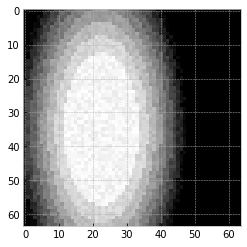

In [130]:
y1 = 7
y2 = 9
a = 5
b = 2.5
r2 = 100
p = 0

lesion_prior = 0*copy.copy(I)
while r2 > 10:
    #add lesion
    
    for i in range(lesion_prior[0,0,:,:].shape[0]):
        for j in range(lesion_prior[0,0,:,:].shape[1]):
            if ((i/a)-y1)**2 + ((j/b)-y2)**2 < r2:
                lesion_prior[0,0,i,j] = p + rn.uniform(0,0.15)
    r2-=10
    p+=0.2
    
lesion_prior = (1/lesion_prior.max())*lesion_prior
plt.imshow(lesion_prior[0,0,:,:],cmap='gray')

`I0` and `I1` effectively constitute a batch of size 1. Hence, the numpy array is of shape `1x1x64x64`.

Size I: (1, 1, 64, 64)
Size T: (1, 1, 64, 64)


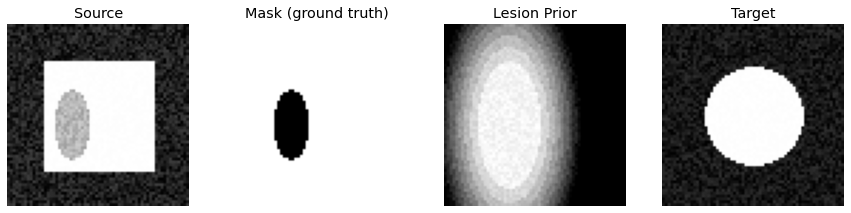

In [131]:
print('Size I:', I.shape)
print('Size T:', T.shape)
plt.figure(figsize=(15,5))
plt.subplot(141)
plt.imshow(I[0,0,:,:],cmap='gray')
plt.title('Source')
plt.axis('off');

plt.subplot(142)
plt.imshow(mask[0,0,:,:],cmap='gray')
plt.title('Mask (ground truth)')
plt.axis('off');

plt.subplot(143)
plt.imshow(lesion_prior[0,0,:,:],cmap='gray')
plt.title('Lesion Prior')
plt.axis('off');

plt.subplot(144)
plt.imshow(T[0,0,:,:],cmap='gray')
plt.title('Target')
plt.axis('off');

Alternatively, we can also create an example pair of realistic 2D MRI slices with spacing normalized to $[0,1]$. In that case, images are of size `1x1x128x128`.

In [132]:
def show_image(I, title):
    plt.imshow(I[0,0,:,:], cmap='gray')
    plt.axis('off')
    plt.title(title)

Next, we are ready to create an instance of `SI.RegisterImagePair` and show all available registration models to select from.

In [133]:
si = SI.RegisterImagePair()
si.print_available_models()


Known registration models are:
------------------------------
                              affine_map: map-based affine registration
                           diffusion_map: displacement-based diffusion registration
                           curvature_map: displacement-based curvature registration
                     total_variation_map: displacement-based total variation registration
                                 svf_map: map-based stationary velocity field
                               svf_image: image-based stationary velocity field
               svf_scalar_momentum_image: image-based stationary velocity field using the scalar momentum
                 svf_scalar_momentum_map: map-based stationary velocity field using the scalar momentum
               svf_vector_momentum_image: image-based stationary velocity field using the vector momentum
                 svf_vector_momentum_map: map-based stationary velocity field using the vector momentum
                      lddmm_s

That's basically it. We can now simply use the `register_images` method of `SI.RegisterImagePair` with appropriate parameters. 

In the following examples of different registration models, we will always keep track of all intermediate results by 
setting the `recording_step` to 1, i.e., we record the intermediate results in each optimization iteration and turn visualization off, as we will visualize the results later by hand. You can also set `recording_step` to `None` in which case nothing is recorded. 

Also, you can set `visualization_step` to a non-zero value which will produce an overview plot of the intermediate registration results at the given visualization steps.

# Registration


## Registration with mask

Loading parameter file = params.json
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Overwriting key = name; category = root.optimizer; value =  sgd -> sgd
Overwriting key = nr_of_iterations; category = root.optimizer.single_scale; value =  1 -> 50
Overwriting key = type; category = root.model.registration_model.similarity_measure; value =  ssd -> ssd
Overwriting key = rel_ftol; category = root.optimizer.single_scale; value =  0.0001 -> 1e-07
mapLowResFactor = 1: performing computations at original resolution.
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = map_low_res_factor; category = root.model.deformation; value =  1.0 -> 1.0
Creating new category: root.optimizer.multi_scale
Using default value = [1.0, 0.5, 0.25] for key = scale_factors of category = root.optimizer.multi_scale
U

<Figure size 432x288 with 0 Axes>

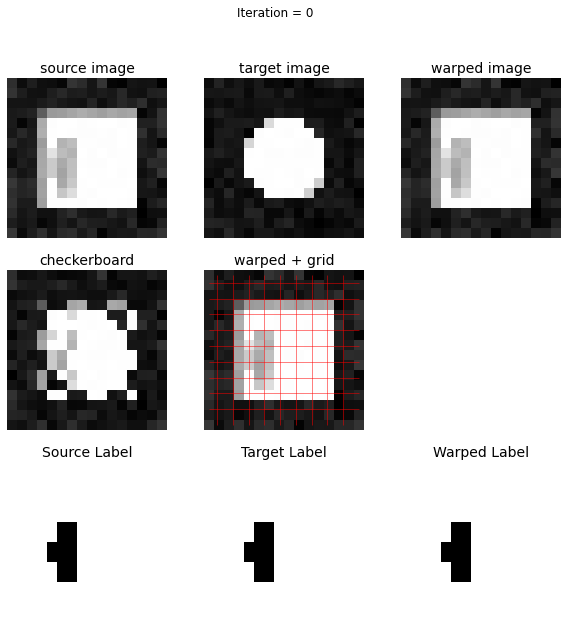

    1-Tot: E=005.3881 | simE=005.3711 | regE=000.0170 | optParE=000.0000 | relF=000.4192 | 
    1-Img: E=005.3881 | simE=005.3711 | regE=000.0170 |
    2-Tot: E=003.7738 | simE=003.7492 | regE=000.0246 | optParE=000.0000 | relF=000.3382 | 
    2-Img: E=003.7738 | simE=003.7492 | regE=000.0246 |
    3-Tot: E=002.9078 | simE=002.8758 | regE=000.0320 | optParE=000.0000 | relF=000.2216 | 
    3-Img: E=002.9078 | simE=002.8758 | regE=000.0320 |
    4-Tot: E=002.3277 | simE=002.2875 | regE=000.0402 | optParE=000.0000 | relF=000.1743 | 
    4-Img: E=002.3277 | simE=002.2875 | regE=000.0402 |
    5-Tot: E=001.5802 | simE=001.5310 | regE=000.0492 | optParE=000.0000 | relF=000.2897 | 
    5-Img: E=001.5802 | simE=001.5310 | regE=000.0492 |


<Figure size 432x288 with 0 Axes>

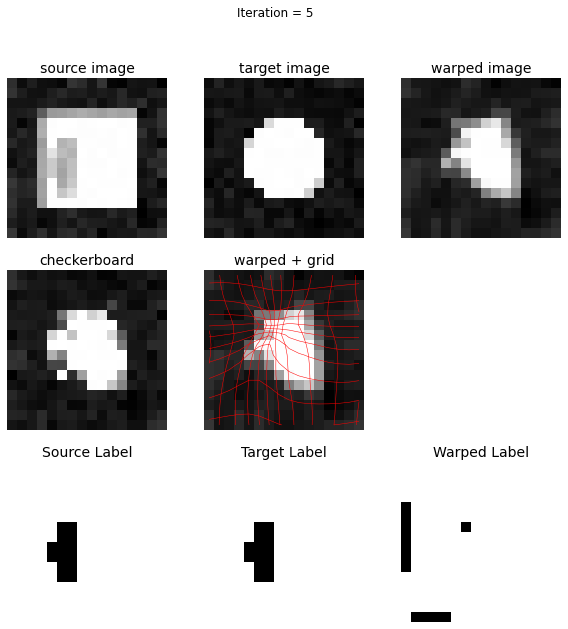

    6-Tot: E=001.0830 | simE=001.0235 | regE=000.0595 | optParE=000.0000 | relF=000.2387 | 
    6-Img: E=001.0830 | simE=001.0235 | regE=000.0595 |
    7-Tot: E=000.9933 | simE=000.9206 | regE=000.0726 | optParE=000.0000 | relF=000.0450 | 
    7-Img: E=000.9933 | simE=000.9206 | regE=000.0726 |
    8-Tot: E=000.8247 | simE=000.7406 | regE=000.0842 | optParE=000.0000 | relF=000.0924 | 
    8-Img: E=000.8247 | simE=000.7406 | regE=000.0842 |
    9-Tot: E=000.7697 | simE=000.6728 | regE=000.0969 | optParE=000.0000 | relF=000.0311 | 
    9-Img: E=000.7697 | simE=000.6728 | regE=000.0969 |
   10-Tot: E=000.7553 | simE=000.6467 | regE=000.1086 | optParE=000.0000 | relF=000.0082 | 
   10-Img: E=000.7553 | simE=000.6467 | regE=000.1086 |


<Figure size 432x288 with 0 Axes>

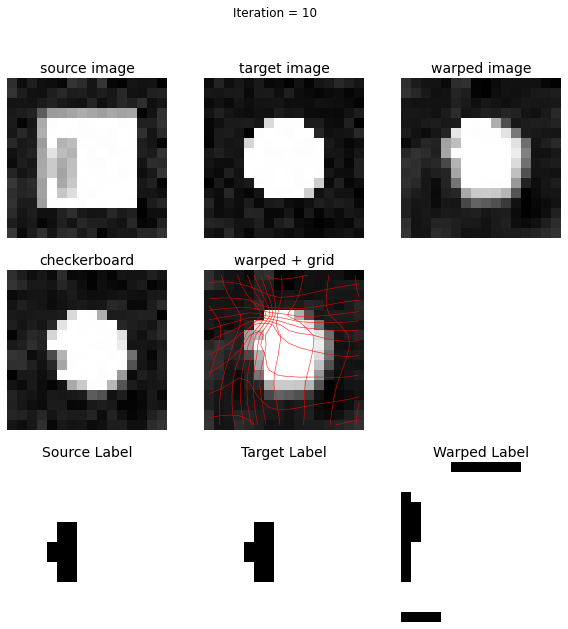

   11-Tot: E=000.7470 | simE=000.6276 | regE=000.1194 | optParE=000.0000 | relF=000.0048 | 
   11-Img: E=000.7470 | simE=000.6276 | regE=000.1194 |
   12-Tot: E=000.7560 | simE=000.6271 | regE=000.1289 | optParE=000.0000 | relF=000.0051 | 
   12-Img: E=000.7560 | simE=000.6271 | regE=000.1289 |
   13-Tot: E=000.8155 | simE=000.6785 | regE=000.1370 | optParE=000.0000 | relF=000.0328 | 
   13-Img: E=000.8155 | simE=000.6785 | regE=000.1370 |
   14-Tot: E=000.8617 | simE=000.7201 | regE=000.1416 | optParE=000.0000 | relF=000.0248 | 
   14-Img: E=000.8617 | simE=000.7201 | regE=000.1416 |
   15-Tot: E=000.8101 | simE=000.6630 | regE=000.1472 | optParE=000.0000 | relF=000.0285 | 
   15-Img: E=000.8101 | simE=000.6630 | regE=000.1472 |


<Figure size 432x288 with 0 Axes>

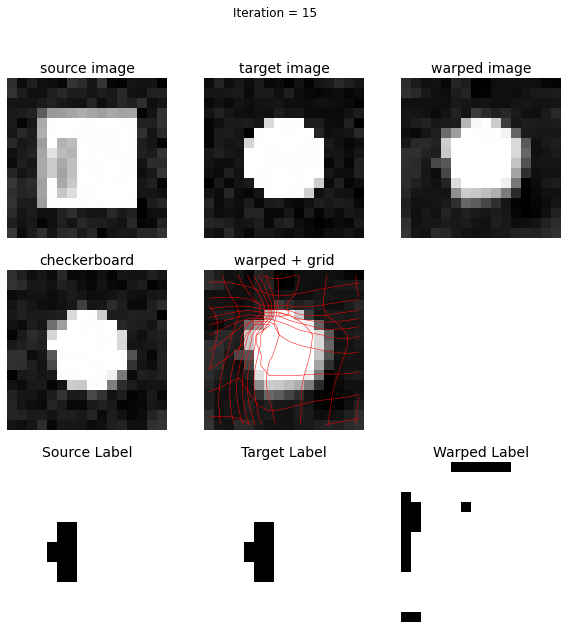

   16-Tot: E=000.7121 | simE=000.5635 | regE=000.1486 | optParE=000.0000 | relF=000.0573 | 
   16-Img: E=000.7121 | simE=000.5635 | regE=000.1486 |
   17-Tot: E=000.6793 | simE=000.5283 | regE=000.1510 | optParE=000.0000 | relF=000.0195 | 
   17-Img: E=000.6793 | simE=000.5283 | regE=000.1510 |
   18-Tot: E=000.6521 | simE=000.5001 | regE=000.1519 | optParE=000.0000 | relF=000.0165 | 
   18-Img: E=000.6521 | simE=000.5001 | regE=000.1519 |
   19-Tot: E=000.6075 | simE=000.4545 | regE=000.1531 | optParE=000.0000 | relF=000.0277 | 
   19-Img: E=000.6075 | simE=000.4545 | regE=000.1531 |


<Figure size 432x288 with 0 Axes>

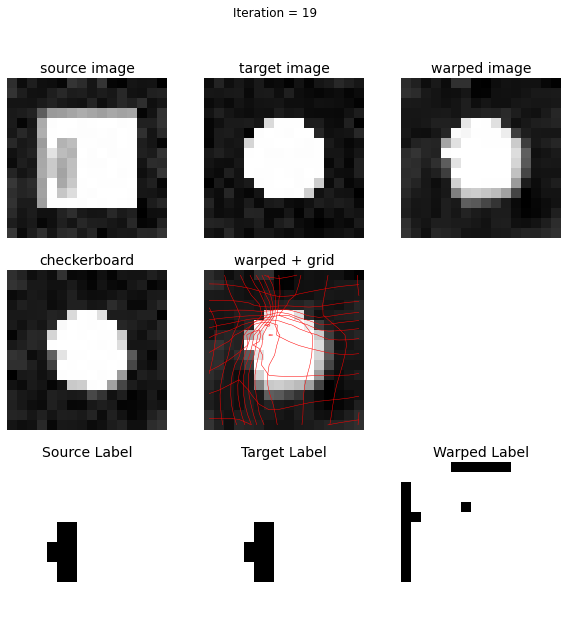

-->Elapsed time 15.20343[s]
Before
[ 1  1 32 32]
Optimizing for scale = 0.5
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = map_low_res_factor; category = root.model.deformation; value =  None -> None
Setting learning rate to None
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Using map-based lddmm_shooting_map model
the param of smoother is <mermaid.smoother_factory.MultiGaussianFourierSmoother object at 0x1359419d0>
works in mermaid iter mode
LDDMMShootingVectorMomentumMapNet(
  (integrator): ODEWrapBlock()
)
Overwriting key = name; category = root.optimizer; value =  sgd -> sgd
Overwriting key = rel_ftol; category = root.optimizer.single_scale; value =  1e-07 -> 1e-07
Explicitly setting the optimization parameters
Optimizing for at most 20 iteratio

<Figure size 432x288 with 0 Axes>

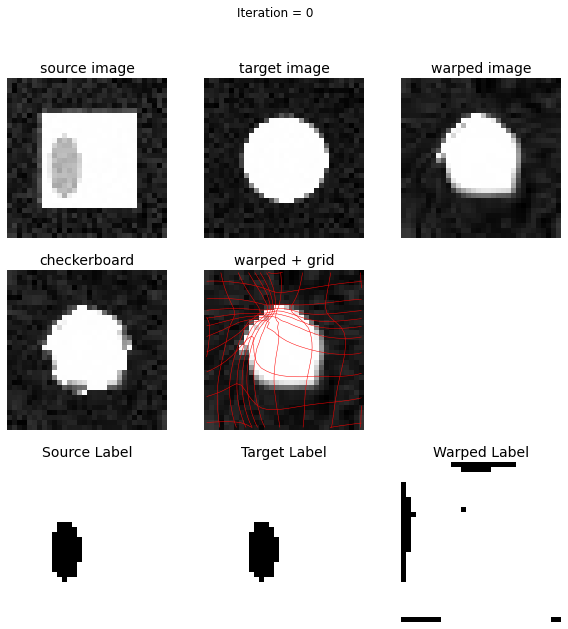

    1-Tot: E=001.2351 | simE=001.0911 | regE=000.1440 | optParE=000.0000 | relF=000.1071 | 
    1-Img: E=001.2351 | simE=001.0911 | regE=000.1440 |
    2-Tot: E=001.0836 | simE=000.9408 | regE=000.1428 | optParE=000.0000 | relF=000.0727 | 
    2-Img: E=001.0836 | simE=000.9408 | regE=000.1428 |
    3-Tot: E=000.9306 | simE=000.7893 | regE=000.1413 | optParE=000.0000 | relF=000.0793 | 
    3-Img: E=000.9306 | simE=000.7893 | regE=000.1413 |
    4-Tot: E=000.8255 | simE=000.6856 | regE=000.1399 | optParE=000.0000 | relF=000.0576 | 
    4-Img: E=000.8255 | simE=000.6856 | regE=000.1399 |
    5-Tot: E=000.7868 | simE=000.6482 | regE=000.1386 | optParE=000.0000 | relF=000.0217 | 
    5-Img: E=000.7868 | simE=000.6482 | regE=000.1386 |


<Figure size 432x288 with 0 Axes>

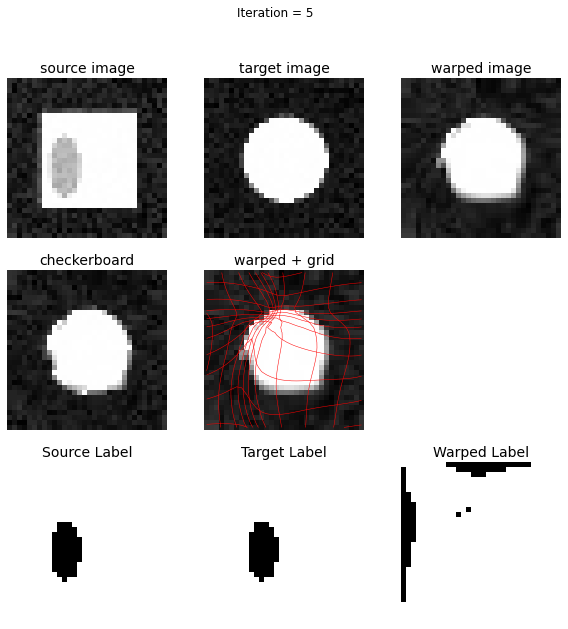

    6-Tot: E=000.7813 | simE=000.6438 | regE=000.1376 | optParE=000.0000 | relF=000.0031 | 
    6-Img: E=000.7813 | simE=000.6438 | regE=000.1376 |
    7-Tot: E=000.7871 | simE=000.6504 | regE=000.1367 | optParE=000.0000 | relF=000.0032 | 
    7-Img: E=000.7871 | simE=000.6504 | regE=000.1367 |
    8-Tot: E=000.7825 | simE=000.6464 | regE=000.1361 | optParE=000.0000 | relF=000.0026 | 
    8-Img: E=000.7825 | simE=000.6464 | regE=000.1361 |
    9-Tot: E=000.7585 | simE=000.6229 | regE=000.1356 | optParE=000.0000 | relF=000.0136 | 
    9-Img: E=000.7585 | simE=000.6229 | regE=000.1356 |
   10-Tot: E=000.7215 | simE=000.5863 | regE=000.1352 | optParE=000.0000 | relF=000.0215 | 
   10-Img: E=000.7215 | simE=000.5863 | regE=000.1352 |


<Figure size 432x288 with 0 Axes>

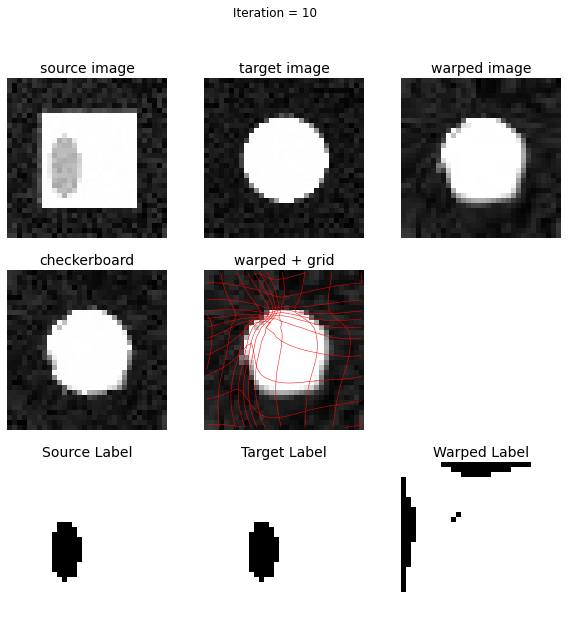

   11-Tot: E=000.6866 | simE=000.5517 | regE=000.1349 | optParE=000.0000 | relF=000.0207 | 
   11-Img: E=000.6866 | simE=000.5517 | regE=000.1349 |
   12-Tot: E=000.6561 | simE=000.5214 | regE=000.1346 | optParE=000.0000 | relF=000.0185 | 
   12-Img: E=000.6561 | simE=000.5214 | regE=000.1346 |
   13-Tot: E=000.6309 | simE=000.4965 | regE=000.1343 | optParE=000.0000 | relF=000.0154 | 
   13-Img: E=000.6309 | simE=000.4965 | regE=000.1343 |
   14-Tot: E=000.6125 | simE=000.4786 | regE=000.1339 | optParE=000.0000 | relF=000.0114 | 
   14-Img: E=000.6125 | simE=000.4786 | regE=000.1339 |
   15-Tot: E=000.5975 | simE=000.4641 | regE=000.1334 | optParE=000.0000 | relF=000.0094 | 
   15-Img: E=000.5975 | simE=000.4641 | regE=000.1334 |


<Figure size 432x288 with 0 Axes>

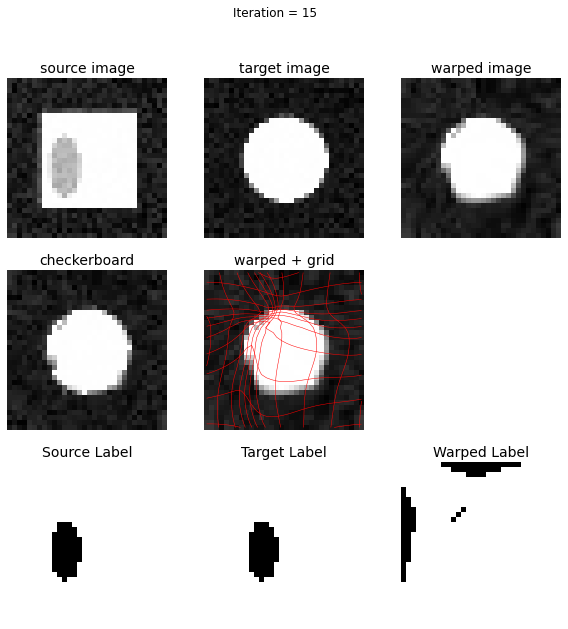

   16-Tot: E=000.5858 | simE=000.4531 | regE=000.1327 | optParE=000.0000 | relF=000.0074 | 
   16-Img: E=000.5858 | simE=000.4531 | regE=000.1327 |
   17-Tot: E=000.5739 | simE=000.4419 | regE=000.1320 | optParE=000.0000 | relF=000.0076 | 
   17-Img: E=000.5739 | simE=000.4419 | regE=000.1320 |
   18-Tot: E=000.5638 | simE=000.4327 | regE=000.1311 | optParE=000.0000 | relF=000.0064 | 
   18-Img: E=000.5638 | simE=000.4327 | regE=000.1311 |
   19-Tot: E=000.5503 | simE=000.4201 | regE=000.1302 | optParE=000.0000 | relF=000.0087 | 
   19-Img: E=000.5503 | simE=000.4201 | regE=000.1302 |


<Figure size 432x288 with 0 Axes>

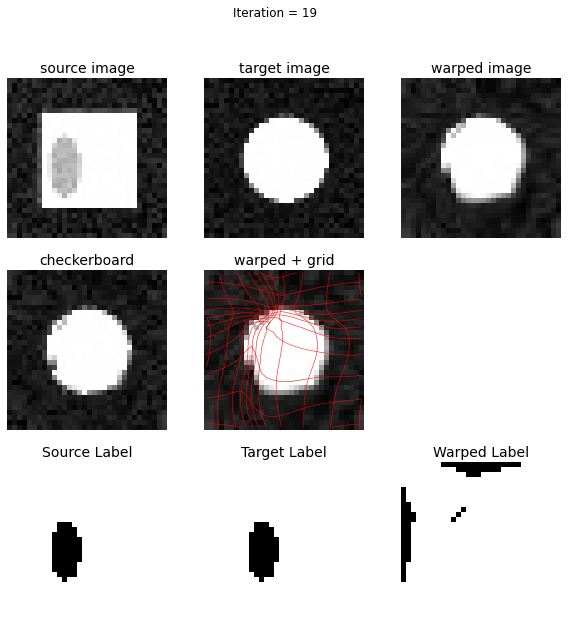

-->Elapsed time 14.35108[s]
Before
[ 1  1 64 64]
Optimizing for scale = 1.0
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = map_low_res_factor; category = root.model.deformation; value =  None -> None
Setting learning rate to None
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Using map-based lddmm_shooting_map model
the param of smoother is <mermaid.smoother_factory.MultiGaussianFourierSmoother object at 0x134324850>
works in mermaid iter mode
LDDMMShootingVectorMomentumMapNet(
  (integrator): ODEWrapBlock()
)
Overwriting key = name; category = root.optimizer; value =  sgd -> sgd
Overwriting key = rel_ftol; category = root.optimizer.single_scale; value =  1e-07 -> 1e-07
Explicitly setting the optimization parameters
Optimizing for at most 10 iteratio

<Figure size 432x288 with 0 Axes>

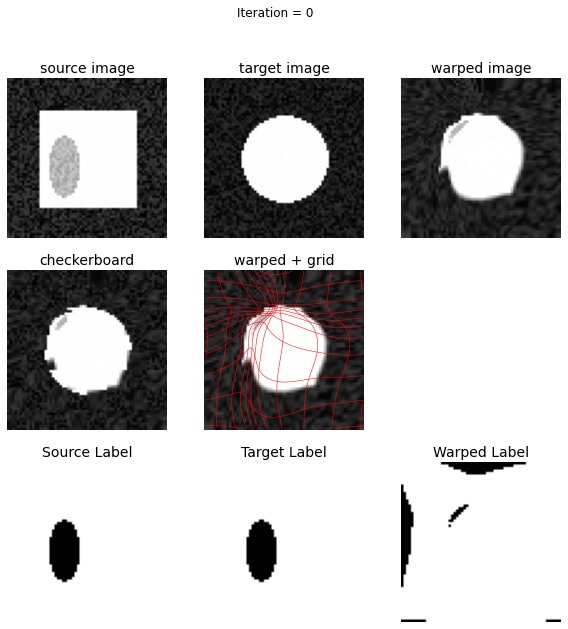

    1-Tot: E=001.1797 | simE=001.0533 | regE=000.1264 | optParE=000.0000 | relF=000.0409 | 
    1-Img: E=001.1797 | simE=001.0533 | regE=000.1264 |
    2-Tot: E=001.1073 | simE=000.9813 | regE=000.1260 | optParE=000.0000 | relF=000.0344 | 
    2-Img: E=001.1073 | simE=000.9813 | regE=000.1260 |
    3-Tot: E=001.0342 | simE=000.9088 | regE=000.1254 | optParE=000.0000 | relF=000.0359 | 
    3-Img: E=001.0342 | simE=000.9088 | regE=000.1254 |
    4-Tot: E=000.9577 | simE=000.8328 | regE=000.1249 | optParE=000.0000 | relF=000.0391 | 
    4-Img: E=000.9577 | simE=000.8328 | regE=000.1249 |
    5-Tot: E=000.8802 | simE=000.7559 | regE=000.1243 | optParE=000.0000 | relF=000.0412 | 
    5-Img: E=000.8802 | simE=000.7559 | regE=000.1243 |


<Figure size 432x288 with 0 Axes>

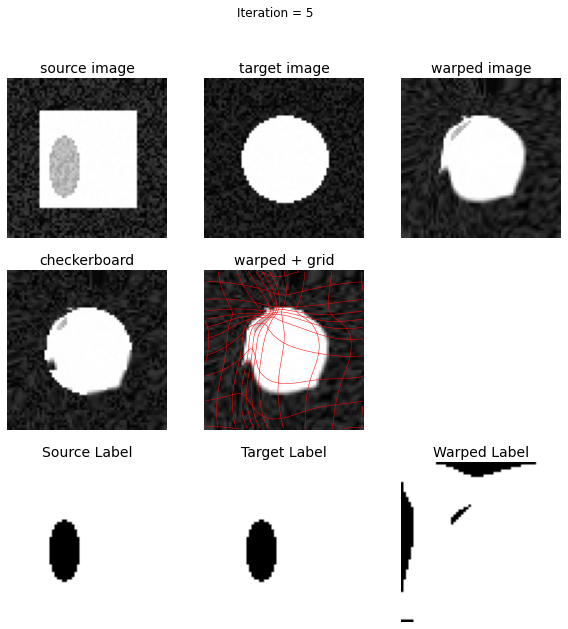

    6-Tot: E=000.8672 | simE=000.7434 | regE=000.1238 | optParE=000.0000 | relF=000.0070 | 
    6-Img: E=000.8672 | simE=000.7434 | regE=000.1238 |
    7-Tot: E=000.8404 | simE=000.7170 | regE=000.1234 | optParE=000.0000 | relF=000.0145 | 
    7-Img: E=000.8404 | simE=000.7170 | regE=000.1234 |
    8-Tot: E=000.8149 | simE=000.6918 | regE=000.1231 | optParE=000.0000 | relF=000.0140 | 
    8-Img: E=000.8149 | simE=000.6918 | regE=000.1231 |
    9-Tot: E=000.8128 | simE=000.6900 | regE=000.1229 | optParE=000.0000 | relF=000.0011 | 
    9-Img: E=000.8128 | simE=000.6900 | regE=000.1229 |


<Figure size 432x288 with 0 Axes>

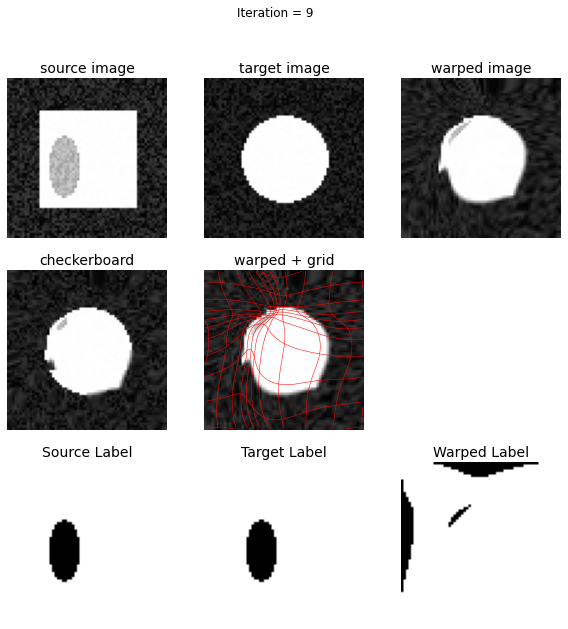

-->Elapsed time 12.31328[s]
Writing parameter file = used_params.json
Writing parameter file = used_params_with_comments.json


In [134]:
si.register_images( 
                    ISource=I,
                    ITarget=T,
                    spacing=spacing, 
                    model_name='svf_vector_momentum_image',
                    LSource=mask,
                    LTarget=mask,
                    nr_of_iterations=50,
                    similarity_measure_type = 'ssd',
                    use_multi_scale=True,
                    visualize_step=5,
                    optimizer_name='sgd',
                    learning_rate=0.15,
                    rel_ftol=1e-7,
                    json_config_out_filename=('used_params.json','used_params_with_comments.json'),
                    params='params.json',
                    recording_step=1
                  )

## Registration with no mask

Loading parameter file = params.json
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = type; category = root.model.registration_model; value =  lddmm_shooting_map -> lddmm_shooting_map
Overwriting key = name; category = root.optimizer; value =  sgd -> sgd
Overwriting key = nr_of_iterations; category = root.optimizer.single_scale; value =  1 -> 50
Overwriting key = type; category = root.model.registration_model.similarity_measure; value =  ssd -> ssd
Overwriting key = rel_ftol; category = root.optimizer.single_scale; value =  0.0001 -> 1e-07
mapLowResFactor = 1: performing computations at original resolution.
Overwriting key = use_map; category = root.model.deformation; value =  True -> True
Overwriting key = map_low_res_factor; category = root.model.deformation; value =  1.0 -> 1.0
Creating new category: root.optimizer.multi_scale
Using default value = [1.0, 0.5, 0.25] for key = scale_factors of category = root.optimizer.multi_scale
U

<Figure size 432x288 with 0 Axes>

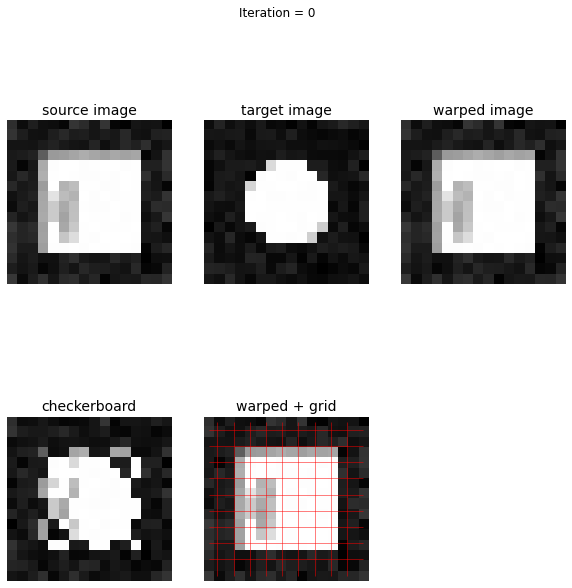

    1-Tot: E=005.8844 | simE=005.8672 | regE=000.0172 | optParE=000.0000 | relF=000.3738 | 
    1-Img: E=005.8844 | simE=005.8672 | regE=000.0172 |
    2-Tot: E=004.1779 | simE=004.1545 | regE=000.0234 | optParE=000.0000 | relF=000.3296 | 
    2-Img: E=004.1779 | simE=004.1545 | regE=000.0234 |
    3-Tot: E=003.3738 | simE=003.3448 | regE=000.0290 | optParE=000.0000 | relF=000.1839 | 
    3-Img: E=003.3738 | simE=003.3448 | regE=000.0290 |
    4-Tot: E=002.7201 | simE=002.6855 | regE=000.0346 | optParE=000.0000 | relF=000.1757 | 
    4-Img: E=002.7201 | simE=002.6855 | regE=000.0346 |
    5-Tot: E=001.4696 | simE=001.4295 | regE=000.0401 | optParE=000.0000 | relF=000.5063 | 
    5-Img: E=001.4696 | simE=001.4295 | regE=000.0401 |


<Figure size 432x288 with 0 Axes>

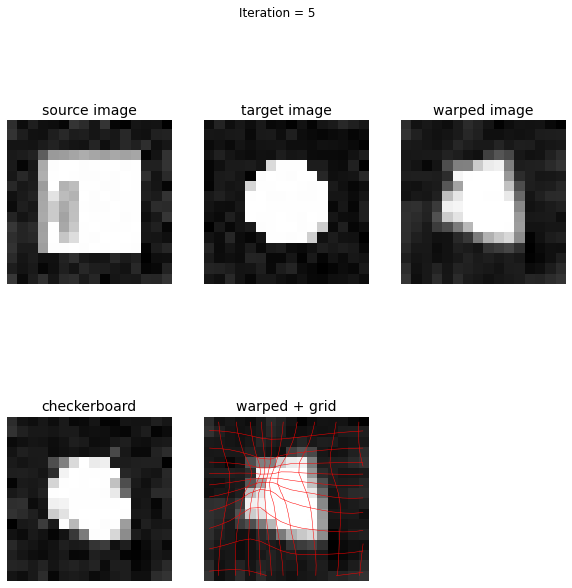

    6-Tot: E=001.0741 | simE=001.0270 | regE=000.0472 | optParE=000.0000 | relF=000.1907 | 
    6-Img: E=001.0741 | simE=001.0270 | regE=000.0472 |


In [ ]:
sim.mask = 1
si.register_images( 
                    ISource=I,
                    ITarget=T,
                    spacing=spacing, 
                    model_name='svf_vector_momentum_image',
                    #LSource=mask,
                    #LTarget=mask,
                    nr_of_iterations=50,
                    similarity_measure_type = 'ssd',
                    use_multi_scale=True,
                    visualize_step=5,
                    optimizer_name='sgd',
                    learning_rate=0.15,
                    rel_ftol=1e-7,
                    json_config_out_filename=('used_params.json','used_params_with_comments.json'),
                    params='params.json',
                    recording_step=1
                  )

We now fetch our registration history to access all intermediate results.

In [56]:
h = si.get_history()
h

{'recording': []}

In [14]:
type(h['recording'][-1]['iWL'])

NoneType

First, we plot the source/target as well as the warped result. For this, we simply access the last optimization iteration and collect the source/target and warped image which are stored in `h['recording'][-1]` and can be accessed via the keys `iS`, `iT` and `iW`.

In [38]:
"""
plt.figure(figsize=(15,5))
plt.subplot(131); show_image(h['recording'][-1]['iS'], 'Source image')
plt.subplot(132); show_image(h['recording'][-1]['iT'], 'Target image')
plt.subplot(133); show_image(h['recording'][-1]['iW'], 'Warped image')
"""

"\nplt.figure(figsize=(15,5))\nplt.subplot(131); show_image(h['recording'][-1]['iS'], 'Source image')\nplt.subplot(132); show_image(h['recording'][-1]['iT'], 'Target image')\nplt.subplot(133); show_image(h['recording'][-1]['iW'], 'Warped image')\n"

We can also show a simple **checkerboard plot** using `mermaid.visualize_registration_results.checkerboard_2d` as follows:

In [40]:
"""
from mermaid.visualize_registration_results import checkerboard_2d

iT = h['recording'][-1]['iT'][0,0,:,:]
iW = h['recording'][-1]['iW'][0,0,:,:]

cb_img = checkerboard_2d(iT,iW)
plt.imshow(cb_img ,cmap='gray')
plt.axis('off')
plt.title('Checkerboard (Target vs. Warped)');
"""

"\nfrom mermaid.visualize_registration_results import checkerboard_2d\n\niT = h['recording'][-1]['iT'][0,0,:,:]\niW = h['recording'][-1]['iW'][0,0,:,:]\n\ncb_img = checkerboard_2d(iT,iW)\nplt.imshow(cb_img ,cmap='gray')\nplt.axis('off')\nplt.title('Checkerboard (Target vs. Warped)');\n"

It's also quite simple to plot the corresponding **deformation grid** (i.e., at the final optimization iteration) as follows:

In [40]:
def show_warped_with_grid(I, phi, title):
    plt.imshow(I[0,0,:,:] ,cmap='gray')
    plt.contour(phi[0, 0, :, :], 
            np.linspace(-1, 1, 20),
            colors='r', 
            linestyles='solid',
            linewidths=0.5)
    plt.contour(phi[0, 1, :, :], 
            np.linspace(-1, 1, 20),
            colors='r', 
            linestyles='solid',
            linewidths=0.5)

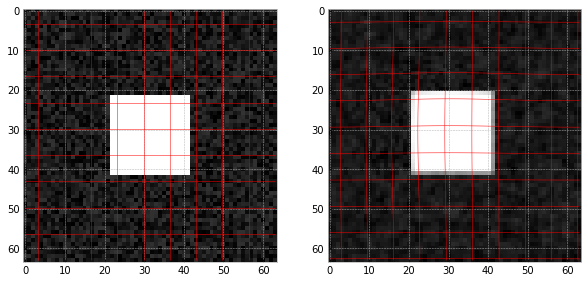

In [41]:
plt.figure(figsize=(10,5))
plt.subplot(121); show_warped_with_grid(h['recording'][0]['iW'], 
                                        h['recording'][0]['phiWarped'], 
                                        'Deformation (at iteration {})'.format(0))
plt.subplot(122); show_warped_with_grid(h['recording'][-1]['iW'], 
                                        h['recording'][-1]['phiWarped'], 
                                        'Deformation (at convergence)')

Additionally, lets show the energy terms over the optimization iterations ...

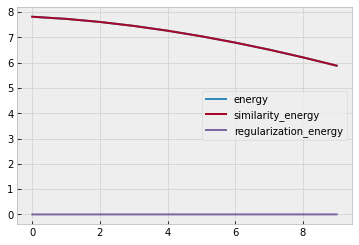

In [192]:
e_p, = plt.plot(h['energy'], label='energy')
s_p, = plt.plot(h['similarity_energy'], label='similarity_energy')
r_p, = plt.plot(h['regularization_energy'], label='regularization_energy')
plt.legend(handles=[e_p,s_p,r_p])
plt.show()

## Using mermaids visualization

In [44]:
"""
import torch
import mermaid.utils as utils
import mermaid.visualize_registration_results as vizreg

I_0 = torch.from_numpy(I0_syn)
I_1 = torch.from_numpy(I1_syn)
phi = si.get_map()
I_W = utils.compute_warped_image_multiNC(I_0, 
                                         phi, 
                                         spacing_syn, 
                                         spline_order=1)
vizreg.show_current_images(len(si.get_history()['energy']), 
                           I_0, 
                           I_1, 
                           I_W, 
                           phiWarped=phi)
"""

"\nimport torch\nimport mermaid.utils as utils\nimport mermaid.visualize_registration_results as vizreg\n\nI_0 = torch.from_numpy(I0_syn)\nI_1 = torch.from_numpy(I1_syn)\nphi = si.get_map()\nI_W = utils.compute_warped_image_multiNC(I_0, \n                                         phi, \n                                         spacing_syn, \n                                         spline_order=1)\nvizreg.show_current_images(len(si.get_history()['energy']), \n                           I_0, \n                           I_1, \n                           I_W, \n                           phiWarped=phi)\n"